##### Pomegranate Api Practice

In [1]:
%load_ext autoreload
%aimport helpers
%autoreload 1

In [2]:
import pomegranate
pomegranate.utils.enable_gpu()

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from helpers import show_model
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

In [4]:
model = HiddenMarkovModel(name="First HMM")

sunny_emmissions = DiscreteDistribution({"yes": 0.1, "no": 0.9})
sunny_state = State(sunny_emmissions, name="Sunny")

rainy_emmisions = DiscreteDistribution({"yes": 0.8, "no": 0.2})
rainy_state = State(rainy_emmisions, name="Rainy")

model.add_states(sunny_state, rainy_state)

In [5]:
assert rainy_emmisions.probability("yes") == 0.8
print("OK")

OK


In [6]:
# Adding transitions

# Initially all will be 0.5
model.add_transition(model.start, sunny_state, 0.5)
model.add_transition(model.start, rainy_state, 0.5)

# transition from sunny state
model.add_transition(sunny_state, sunny_state, 0.8)
model.add_transition(sunny_state, rainy_state, 0.2)

# transition from rainy state
model.add_transition(rainy_state, sunny_state, 0.4)
model.add_transition(rainy_state, rainy_state, 0.6)

model.bake()

assert model.edge_count() == 6
assert model.node_count() == 4
print("OK")

OK


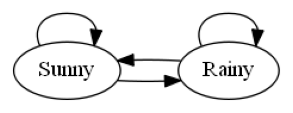

In [7]:
show_model(model, figsize=(5, 5), filename="sampleHMM.png", overwrite=True, show_ends=False)

In [8]:
column_order = ["First HMM-start", "Sunny", "Rainy", "First HMM-end"]
column_names = [s.name for s in model.states]
order_index = [column_names.index(c) for c in column_order]

transitions = model.dense_transition_matrix()[:, order_index][order_index, :]
print("The state transition matrix, P(Xt|Xt-1):\n")
print(transitions)
print("\nThe transition probability from Rainy to Sunny is {:.0f}%".format(100 * transitions[2, 1]))

The state transition matrix, P(Xt|Xt-1):

[[0.  0.5 0.5 0. ]
 [0.  0.8 0.2 0. ]
 [0.  0.4 0.6 0. ]
 [0.  0.  0.  0. ]]

The transition probability from Rainy to Sunny is 40%


##### Calculating likelihood probabilites of given sequences

In [9]:
observations = ["yes", "no", "yes"]

assert len(observations) > 0
# forward method returns log likelihood so using np.exp for getting likelihood probability

forward_matrix = np.exp(model.forward(observations))
forward_matrix

array([[0.    , 0.    , 1.    , 0.    ],
       [0.4   , 0.05  , 0.    , 0.    ],
       [0.05  , 0.18  , 0.    , 0.    ],
       [0.0528, 0.0164, 0.    , 0.    ]])

In [10]:
probability_percentage = np.exp(model.log_probability(observations))
probability_percentage

0.06920000000000004

In [11]:
# Display the forward probabilities
print("         " + "".join(s.name.center(len(s.name)+6) for s in model.states))
for i in range(len(observations) + 1):
    print(" <start> " if i==0 else observations[i - 1].center(9), end="")
    print("".join("{:.0f}%".format(100 * forward_matrix[i, j]).center(len(s.name) + 6)
                  for j, s in enumerate(model.states)))

print("\nThe likelihood over all possible paths " + \
      "of this model producing the sequence {} is {:.2f}%\n\n"
      .format(observations, 100 * probability_percentage))

            Rainy      Sunny      First HMM-start      First HMM-end   
 <start>      0%         0%             100%                 0%        
   yes       40%         5%              0%                  0%        
    no        5%        18%              0%                  0%        
   yes        5%         2%              0%                  0%        

The likelihood over all possible paths of this model producing the sequence ['yes', 'no', 'yes'] is 6.92%




In [18]:
#Veterbi Algorithm for most likely hidden state sequence and likelihood of veterbi path

veterbi_logprob, veterbipath = model.viterbi(observations)
print(round(np.exp(veterbi_logprob), 3), [s[1].name for s in veterbipath])

0.023 ['First HMM-start', 'Rainy', 'Sunny', 'Rainy']


In [20]:

from itertools import product

observations = ['yes', 'no', 'yes']
#Transition Probability
p = {'Sunny': {'Sunny': np.log(.8), 'Rainy': np.log(.2)}, 'Rainy': {'Sunny': np.log(.4), 'Rainy': np.log(.6)}}
#emmission Probability
e = {'Sunny': {'yes': np.log(.1), 'no': np.log(.9)}, 'Rainy':{'yes':np.log(.8), 'no':np.log(.2)}}
o = observations
k = []
vprob = np.exp(model.viterbi(o)[0])
print("The likelihood of observing {} if the weather sequence is...".format(o))
for s in product(*[['Sunny', 'Rainy']]*3):
    k.append(np.exp(np.log(.5)+e[s[0]][o[0]] + p[s[0]][s[1]] + e[s[1]][o[1]] + p[s[1]][s[2]] + e[s[2]][o[2]]))
    print("\t{} is {:.2f}% {}".format(s, 100 * k[-1], " <-- Viterbi path" if k[-1] == vprob else ""))
print("\nThe total likelihood of observing {} over all possible paths is {:.2f}%".format(o, 100*sum(k)))

The likelihood of observing ['yes', 'no', 'yes'] if the weather sequence is...
	('Sunny', 'Sunny', 'Sunny') is 0.29% 
	('Sunny', 'Sunny', 'Rainy') is 0.58% 
	('Sunny', 'Rainy', 'Sunny') is 0.01% 
	('Sunny', 'Rainy', 'Rainy') is 0.10% 
	('Rainy', 'Sunny', 'Sunny') is 1.15% 
	('Rainy', 'Sunny', 'Rainy') is 2.30%  <-- Viterbi path
	('Rainy', 'Rainy', 'Sunny') is 0.19% 
	('Rainy', 'Rainy', 'Rainy') is 2.30%  <-- Viterbi path

The total likelihood of observing ['yes', 'no', 'yes'] over all possible paths is 6.92%


In [22]:
 for s in product(*[['Sunny', 'Rainy']]*3):
        print(s)

('Sunny', 'Sunny', 'Sunny')
('Sunny', 'Sunny', 'Rainy')
('Sunny', 'Rainy', 'Sunny')
('Sunny', 'Rainy', 'Rainy')
('Rainy', 'Sunny', 'Sunny')
('Rainy', 'Sunny', 'Rainy')
('Rainy', 'Rainy', 'Sunny')
('Rainy', 'Rainy', 'Rainy')


In [23]:
k

[0.0028800000000000023,
 0.00576,
 8e-05,
 0.0009600000000000006,
 0.011520000000000013,
 0.023040000000000005,
 0.0019199999999999996,
 0.023040000000000005]